In [35]:
# Package Imports - feel free to add what you think might be useful!
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from math import log2
from typing import List, Tuple

## Task 3: Quest for Quantum Randomness

### Part A: Truly Different

In [36]:
#Constants

QRNG_API_URL = "https://qrng.idqloud.com/api/1.0"
API_KEY = "aTo4BKRvnc49uRWDk034zaua87vGRXKk9TMLdfkI"

In [37]:
"""
Using the QRNGaaS User Manual provided,
write Python code to get random numbers from IDQuantique's Quantum Random Number Generators.

The API documentation is available at: https://drive.google.com/file/d/1OkyRUP7HC4dbmi8OvoT4EuvXqRVGdsjD/view
You'll probably reuse this code for Task 4. So write it well!

If you are unfamiliar with writing HTTP requests in Python,
https://www.w3schools.com/python/module_requests.asp

If you're really stuck, this can definitely help. Though we encourage you to read the documentation yourself!
https://curlconverter.com/python/
"""


"\nUsing the QRNGaaS User Manual provided,\nwrite Python code to get random numbers from IDQuantique's Quantum Random Number Generators.\n\nThe API documentation is available at: https://drive.google.com/file/d/1OkyRUP7HC4dbmi8OvoT4EuvXqRVGdsjD/view\nYou'll probably reuse this code for Task 4. So write it well!\n\nIf you are unfamiliar with writing HTTP requests in Python,\nhttps://www.w3schools.com/python/module_requests.asp\n\nIf you're really stuck, this can definitely help. Though we encourage you to read the documentation yourself!\nhttps://curlconverter.com/python/\n"

### Class for using API for getting random numbers

In [38]:
class QRNGaaS:
    def __init__(self, api_key: str):
        self.base_url = QRNG_API_URL
        self.headers = {
            "X-API-KEY": api_key,
            "Content-Type": "application/json"
        }
        self.max_batch_size = 64  # Actual API limit (32 for int, 64 for short)
        self.max_double_batch = 16

    def get_random_ints_batched(self, quantity: int) -> List[int]:
        """Get random 32-bit integers with batching to handle API limits"""
        batches = quantity // self.max_batch_size
        remainder = quantity % self.max_batch_size

        results = []
        for _ in range(batches):
            results.extend(self._get_batch(self.max_batch_size))

        if remainder > 0:
            results.extend(self._get_batch(remainder))

        return results

    def _get_batch(self, batch_size: int) -> List[int]:
        """Get a single batch of random integers"""
        params = {"quantity": batch_size}
        try:
            response = requests.get(
                f"{self.base_url}/short",
                headers=self.headers,
                params=params,
                timeout=10  # Add timeout to prevent hanging
            )
            response.raise_for_status()
            return response.json()["data"]
        except requests.exceptions.RequestException as e:
            print(f"API request failed: {e}")
            return []  # Return empty list on failure

    def _get_double_batch(self, batch_size: int, min_val: float, max_val: float) -> List[float]:
        params = {"min": min_val, "max": max_val, "quantity": batch_size}
        try:
            resp = requests.get(f"{self.base_url}/double", headers=self.headers, params=params, timeout=10)
            resp.raise_for_status()
            return resp.json()["data"]
        except requests.RequestException as e:
            print(f"Double batch request failed: {e}")
            return []

    def get_random_doubles_batched(
        self,
        quantity: int,
        min_val: float = 0.0,
        max_val: float = 1.0
    ) -> List[float]:
        """
        Retrieve 'quantity' true-random doubles in [min_val, max_val), batching to respect API limits.
        """
        full_batches = quantity // self.max_double_batch
        remainder = quantity % self.max_double_batch
        result: List[float] = []
        for _ in range(full_batches):
            result.extend(self._get_double_batch(self.max_double_batch, min_val, max_val))
        if remainder:
            result.extend(self._get_double_batch(remainder, min_val, max_val))
        return result



In [39]:
# Initialize QRNG - REPLACE WITH YOUR ACTUAL API KEY
qrng = QRNGaaS(API_KEY)

# Analysis Parameters
SAMPLE_SIZES  = [1,5,10,50,100,250,500,1000,2500,5000]  # Reduced max size due to API limits
BIT_LENGTH = 16  # 16-bit integers
NUM_TRIALS = 3   # Reduced trials to avoid rate limiting
REQUEST_DELAY = 0.1  # Small delay between API calls to avoid rate limiting

### Shanon Entropy Calculation Function

In [40]:
def shannon_entropy(data: List[int], bit_length: int = BIT_LENGTH) -> float:
    """
    Calculate Shannon entropy for a set of integers,
    with results normalized to the theoretical maximum
    """
    if not data:
        return 0.0

    # Calculate observed probabilities
    counts = Counter(data)
    probabilities = [count / len(data) for count in counts.values()]

    # Calculate raw entropy
    raw_entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)

    # For integers in range [0, 2^bit_length-1], the max entropy should be bit_length
    max_possible_entropy = bit_length

    return min(raw_entropy, max_possible_entropy)  # Cap at theoretical maximum

### Bitrate Calculation Function

In [41]:
def calculate_bitrate(qrng: QRNGaaS, num_values: int, bits_per_value: int) -> Tuple[float, float]:
    """Calculate bitrate (bits/sec) with proper batching"""
    start_time = time.time()
    qrng.get_random_ints_batched(num_values)  # Generate the values
    elapsed = time.time() - start_time
    total_bits = num_values * bits_per_value
    return total_bits / elapsed if elapsed > 0 else 0.0, elapsed

In [42]:
"""
To get started, we provide a simple example of how to use the API to generate 10 int16 random numbers.
In particular, observe where we pass in the min and max parameters to specify the range of random numbers we want
and the quantity parameter to specify how many random numbers we want.
Here is the API KEY you will need to use: aTo4BKRvnc49uRWDk034zaua87vGRXKk9TMLdfkI
"""

!curl "https://qrng.idqloud.com/api/1.0/short?max=32767&min=-32768&quantity=10" -X GET -H "X-API-KEY: aTo4BKRvnc49uRWDk034zaua87vGRXKk9TMLdfkI"

{"data":[11526,13984,-28952,-19794,-12489,20142,-20454,2321,22522,-7380],"dataType":"int16"}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    92  100    92    0     0     92      0  0:00:01 --:--:--  0:00:01    92


### Getting values from API for selected sample size and calculating its entropy and bitrate value

In [43]:
"""
You can paste the other environmental entropy based TRNGs from Task 2 and compare the performance
Compare your written QRNG to the previous TRNGs. Be sure to compare them with respect to bitrate and entropy.
"""
# Entropy Analysis
print("Running entropy analysis (this may take a while due to API limits)...")
entropy_values = []
for size in SAMPLE_SIZES:
    time.sleep(REQUEST_DELAY)  # Be gentle with the API
    data = qrng.get_random_ints_batched(size)
    if len(data) != size:
        print(f"Warning: Only got {len(data)}/{size} values")

    entropy = shannon_entropy(data, BIT_LENGTH)
    entropy_values.append(entropy)
    print(f"Sample size: {size}, Entropy: {entropy:.2f} bits")

# Bitrate Analysis
print("\nRunning bitrate analysis...")
bitrates = []
test_size = 1000  # Fixed size for bitrate comparison

for trial in range(NUM_TRIALS):
    time.sleep(REQUEST_DELAY)  # Be gentle with the API
    bitrate, elapsed = calculate_bitrate(qrng, test_size, BIT_LENGTH)
    if bitrate > 0:  # Only record successful trials
        bitrates.append(bitrate)
        print(f"Trial {trial+1}: {bitrate:.2f} bits/sec (took {elapsed:.4f} sec)")
    else:
        print(f"Trial {trial+1} failed")

Running entropy analysis (this may take a while due to API limits)...
Sample size: 1, Entropy: -0.00 bits
Sample size: 5, Entropy: 2.32 bits
Sample size: 10, Entropy: 3.32 bits
Sample size: 50, Entropy: 5.64 bits
Sample size: 100, Entropy: 6.64 bits
Sample size: 250, Entropy: 7.97 bits
Sample size: 500, Entropy: 8.95 bits
Sample size: 1000, Entropy: 9.95 bits
Sample size: 2500, Entropy: 11.26 bits
Sample size: 5000, Entropy: 12.21 bits

Running bitrate analysis...
Trial 1: 1211.83 bits/sec (took 13.2031 sec)
Trial 2: 1337.56 bits/sec (took 11.9621 sec)
Trial 3: 1277.95 bits/sec (took 12.5201 sec)


# Comparing TRNG data:

In [44]:
#import reqd libs
%pip install numpy
%pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import struct
from collections import deque
import time

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


JitterTRNG Implementation:

In [45]:
class JitterRNG:
    def __init__(self, pool_size=256):
        self.entropy_pool = deque(maxlen=pool_size)
        self.pool_size = pool_size
        self.last_time = None

    def _collect_timing_jitter(self, iterations=1000):
        """Collect entropy from timing variations between CPU operations"""
        jitter_data = []

        self.last_time =  time.perf_counter_ns()
        #stores a high-resolution timestamp (in nanoseconds) in the self.last_time variable
        #used as the starting time to later compute the timing difference (or jitter) between two measurements

        for _ in range(iterations):
            """
            We need to introduce variability somehow.
            In the following space, do some arbitrary computation to introduce variability.
            We're not going to judge this part. Just make it reasonable so your notebook
            doesn't take forever to run.
            """
            # TODO: Do some arbitrary computation to introduce variability
            x = 0
            for i in range(69):
              x += (i*420)
            """

            """

            current_time = time.perf_counter_ns()  # TODO: Measure the time again
           # assert current_time != "CHANGE ME" # delete this when you're done


            time_diff = current_time - self.last_time # TODO: Calculate the jitter (timing difference)
            # hint: the JitterRNG class has a last_time attribute,
            # and you just computed the current time.
            #assert time_diff != "CHANGE ME" # delete this when you're done

            # Extract the least significant bits of the time difference
            # This is where the true randomness comes from
            lsb = time_diff & 255 # TODO: Get the lowest 8 bits of time_diff
            # hint: bitwise ops
            #assert lsb != "CHANGE ME" # delete this when you're done
            jitter_data.append(lsb)

            self.last_time = current_time # TODO: update self.last_time for next iteration
            #assert self.last_time != "CHANGE ME" # delete this when you're done

        return jitter_data

    def fill_entropy_pool(self):
        """Fill the entropy pool with timing jitter data"""
        # Collect enough jitter samples to fill the pool
        jitter_data = self._collect_timing_jitter(self.pool_size)

        # Add to the entropy pool
        for value in jitter_data:
            self.entropy_pool.append(value)

        return jitter_data

    def get_random_bytes(self, num_bytes=32):
        """Generate random bytes using the entropy pool"""
        # Make sure we have enough entropy
        if len(self.entropy_pool) < self.pool_size:
            self.fill_entropy_pool()

        # Mix the entropy pool using SHA-256
        pool_bytes = bytes(self.entropy_pool)
        mixed_entropy = hashlib.sha256(pool_bytes).digest()

        # Create an output buffer
        result = bytearray()

        # Generate requested number of bytes
        while len(result) < num_bytes:
            # Add more entropy to the pool
            self.fill_entropy_pool()

            # Mix new entropy with previous hash
            pool_bytes = bytes(self.entropy_pool)
            h = hashlib.sha256()
            h.update(mixed_entropy)
            h.update(pool_bytes)
            mixed_entropy = h.digest()

            # Add to result
            result.extend(mixed_entropy)

        # Return only the requested number of bytes
        return bytes(result[:num_bytes])

    def get_random_int(self, min_val=0, max_val=100):
        """Generate a random integer between min_val and max_val (inclusive)"""
        # Calculate how many bytes we need
        range_size = max_val - min_val + 1
        if range_size <= 0:
            raise ValueError("Invalid range")

        # Calculate how many bits we need
        bits_needed = range_size.bit_length()
        bytes_needed = (bits_needed + 7) // 8

        # Get random bytes
        random_bytes = self.get_random_bytes(bytes_needed)

        # Convert bytes to integer
        value = int.from_bytes(random_bytes, byteorder='big')

        # Map to our range
        return min_val + (value % range_size)

    def analyze_randomness(self, sample_size=1000):
        """Analyze the randomness of the generator"""
        # Generate samples
        samples = []
        for _ in range(sample_size):
            samples.append(self.get_random_int(0, 255))

        # Create plots
        plt.figure(figsize=(12, 10))

        # Plot 1: Distribution histogram
        plt.subplot(2, 2, 1)
        plt.hist(samples, bins=32, color='blue', alpha=0.7)
        plt.title('Distribution of Random Values')
        plt.xlabel('Value')
        plt.ylabel('Frequency')

        # Plot 2: Sequential values
        plt.subplot(2, 2, 2)
        plt.plot(samples[:100], '.-', alpha=0.7)
        plt.title('First 100 Generated Values')
        plt.xlabel('Sample Index')
        plt.ylabel('Value')

        # Plot 3: Scatter plot of consecutive values
        plt.subplot(2, 2, 3)
        plt.scatter(samples[:-1], samples[1:], alpha=0.5, s=5)
        plt.title('Scatter Plot of Consecutive Values')
        plt.xlabel('Value n')
        plt.ylabel('Value n+1')

        # Plot 4: Autocorrelation
        plt.subplot(2, 2, 4)
        autocorr = np.correlate(samples, samples, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]
        plt.plot(autocorr[:50])
        plt.title('Autocorrelation')
        plt.xlabel('Lag')
        plt.ylabel('Correlation')

        plt.tight_layout()
        plt.show()

        return samples

Entropy and Bitrate analysis of Jitter TRNG data:

In [46]:
jitter_trng = JitterRNG()

print()
jitter_entropy_values = []

for size in SAMPLE_SIZES:
    data = []
    for i in range(size):
      data.append(jitter_trng.get_random_int(-32768,32767))
    if len(data) != size:
        print(f"Warning: Only got {len(data)}/{size} values")

    entropy = shannon_entropy(data, BIT_LENGTH)
    jitter_entropy_values.append(entropy)
    print(f"Sample size: {size}, Entropy: {entropy:.2f} bits")

def calculate_bitrate_jitter(j_trng: JitterRNG, num_values: int, bits_per_value: int) -> Tuple[float, float]:
    """Calculate bitrate (bits/sec) with proper batching"""
    start_time = time.time()

    # Generate random integers
    for _ in range(num_values):
        j_trng.get_random_int(-32768, 32767)

    elapsed = time.time() - start_time
    total_bits = num_values * bits_per_value
    return total_bits / elapsed if elapsed > 0 else 0.0, elapsed

# Bitrate Analysis
print("\nRunning bitrate analysis...")
jitter_bitrates = []
test_size = 1000  # Fixed size for bitrate comparison

for trial in range(NUM_TRIALS):
    bitrate, elapsed = calculate_bitrate_jitter(jitter_trng, test_size, BIT_LENGTH)
    if bitrate > 0:  # Only record successful trials
        jitter_bitrates.append(bitrate)
        print(f"Trial {trial+1}: {bitrate:.2f} bits/sec (took {elapsed:.4f} sec)")
    else:
        print(f"Trial {trial+1} failed")


Sample size: 1, Entropy: -0.00 bits
Sample size: 5, Entropy: 2.32 bits
Sample size: 10, Entropy: 3.32 bits
Sample size: 50, Entropy: 5.64 bits
Sample size: 100, Entropy: 6.64 bits
Sample size: 250, Entropy: 7.96 bits
Sample size: 500, Entropy: 8.96 bits
Sample size: 1000, Entropy: 9.96 bits
Sample size: 2500, Entropy: 11.24 bits
Sample size: 5000, Entropy: 12.22 bits

Running bitrate analysis...
Trial 1: 9696.22 bits/sec (took 1.6501 sec)
Trial 2: 9898.29 bits/sec (took 1.6164 sec)
Trial 3: 10308.83 bits/sec (took 1.5521 sec)


In [47]:
# Package Imports
%pip install pipwin
%pip install pyaudio
import pyaudio

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


MicrophoneTRNG Implementation:

In [48]:
class MicrophoneRNG:
    def __init__(self, sample_rate=44100, chunk_size=1024, format=pyaudio.paInt16):
        self.sample_rate = sample_rate
        self.chunk_size = chunk_size
        self.format = format
        self.audio = pyaudio.PyAudio()
        self.stream = None
        self.entropy_pool = bytearray()

    def _start_stream(self):
        """Start audio stream if not already running"""
        if self.stream is None or not self.stream.is_active():
            self.stream = self.audio.open(
                format=self.format,
                channels=1,
                rate=self.sample_rate,
                input=True,
                frames_per_buffer=self.chunk_size
            )

    def _stop_stream(self):
        """Stop audio stream if running"""
        if self.stream is not None and self.stream.is_active():
            self.stream.stop_stream()
            self.stream.close()
            self.stream = None

    def collect_entropy(self, duration_seconds=0.5, visualize=False):
        """Collect entropy from microphone for specified duration"""
        self._start_stream() # TODO: start the stream

        frames = []
        num_chunks = int(self.sample_rate * duration_seconds // self.chunk_size) # TODO: compute the number of chunks using the sample rate, duration in seconds, and chunk size.
        # hint: there is a division involved. make sure to cast to int, or use integer division.

        # Read audio data
        for _ in range(max(1, num_chunks)):
            data = self.stream.read(self.chunk_size, exception_on_overflow=False)
            frames.append(data)

        # Convert to numpy array for processing
        if self.format == pyaudio.paInt16:
            format_size = 2  # bytes per sample
            format_char = 'h'  # short integer
        else:
            raise ValueError("Unsupported audio format")

        # Unpack audio data
        audio_data = []
        for frame in frames:
            count = len(frame) // format_size
            fmt = f"{count}{format_char}"
            audio_data.extend(struct.unpack(fmt, frame))

        # Extract entropy from least significant bits
        raw_entropy = bytearray()
        for sample in audio_data:
            # Take the least significant byte (where noise is most prominent)

            lsb = sample & 0xFF # TODO: Get the lowest 8 bits of sample
            # hint: bitwise ops, just like in Part A


            raw_entropy.append(lsb)

        # Visualize if requested
        if visualize:
            plt.figure(figsize=(12, 6))

            # Plot raw audio waveform
            plt.subplot(2, 1, 1)
            plt.plot(audio_data[:1000])
            plt.title("Raw Audio Waveform (first 1000 samples)")
            plt.xlabel("Sample")
            plt.ylabel("Amplitude")

            # Plot histogram of the extracted entropy bytes
            plt.subplot(2, 1, 2)
            plt.hist(raw_entropy, bins=32, color='green', alpha=0.7)
            plt.title("Distribution of Extracted Entropy Bytes")
            plt.xlabel("Byte Value")
            plt.ylabel("Frequency")

            plt.tight_layout()
            plt.show()

        # Add to entropy pool
        self.entropy_pool.extend(raw_entropy)

        return raw_entropy

    def get_random_bytes(self, num_bytes=32):
        """Generate random bytes from the entropy pool"""
        # Make sure we have enough entropy
        while len(self.entropy_pool) < num_bytes * 2:  # Get more than we need
            self.collect_entropy(0.1)

        # Mix entropy with SHA-256
        h = hashlib.sha256()
        h.update(self.entropy_pool)

        # Get a seed from the hash
        seed = h.digest()

        # Generate additional random bytes using the seed
        result = bytearray()
        counter = 0

        while len(result) < num_bytes:
            # Create a unique input for each iteration
            h = hashlib.sha256()
            h.update(seed)
            h.update(counter.to_bytes(4, byteorder='big'))
            result.extend(h.digest())
            counter += 1

        # Remove used entropy from the pool
        self.entropy_pool = self.entropy_pool[num_bytes:]

        return bytes(result[:num_bytes])

    def get_random_int(self, min_val=0, max_val=100):
        """Generate a random integer between min_val and max_val (inclusive)"""
        range_size = max_val - min_val + 1
        if range_size <= 0:
            raise ValueError("Invalid range")

        # Calculate how many bits we need
        bits_needed = range_size.bit_length()
        bytes_needed = (bits_needed + 7) // 8

        # Get random bytes
        random_bytes = self.get_random_bytes(bytes_needed)

        # Convert to integer and map to our range
        value = int.from_bytes(random_bytes, byteorder='big')
        return min_val + (value % range_size)

    def visualize_randomness(self, num_samples=1000):
        """Generate and visualize random numbers"""
        samples = [self.get_random_int(0, 255) for _ in range(num_samples)]

        plt.figure(figsize=(12, 10))

        # Plot 1: Distribution histogram
        plt.subplot(2, 2, 1)
        plt.hist(samples, bins=32, color='blue', alpha=0.7)
        plt.title('Distribution of Random Values')
        plt.xlabel('Value')
        plt.ylabel('Frequency')

        # Plot 2: Sequential values
        plt.subplot(2, 2, 2)
        plt.plot(samples[:100], '.-', alpha=0.7)
        plt.title('First 100 Generated Values')
        plt.xlabel('Sample Index')
        plt.ylabel('Value')

        # Plot 3: Scatter plot of consecutive values
        plt.subplot(2, 2, 3)
        plt.scatter(samples[:-1], samples[1:], alpha=0.5, s=5)
        plt.title('Scatter Plot of Consecutive Values')
        plt.xlabel('Value n')
        plt.ylabel('Value n+1')

        # Plot 4: Autocorrelation
        plt.subplot(2, 2, 4)
        autocorr = np.correlate(samples, samples, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]
        plt.plot(autocorr[:50])
        plt.title('Autocorrelation')
        plt.xlabel('Lag')
        plt.ylabel('Correlation')

        plt.tight_layout()
        plt.show()

        return samples

    def __del__(self):
        """Clean up when object is destroyed"""
        self._stop_stream()
        self.audio.terminate()

Entropy Analysis of data from Microphone TRNG:

In [49]:
mic_trng = MicrophoneRNG()


mic_entropy_values = []

for size in SAMPLE_SIZES:
    data = []
    for i in range(size):
      data.append(mic_trng.get_random_int(-32768,32767))
    if len(data) != size:
        print(f"Warning: Only got {len(data)}/{size} values")

    entropy = shannon_entropy(data, BIT_LENGTH)
    mic_entropy_values.append(entropy)
    print(f"Sample size: {size}, Entropy: {entropy:.2f} bits")

def calculate_bitrate_microphone(micrng: MicrophoneRNG, num_values: int, bits_per_value: int) -> Tuple[float, float]:
    """Calculate bitrate (bits/sec) with proper batching"""
    start_time = time.time()

    # Generate random integers
    for _ in range(num_values):
        micrng.get_random_int(-32768, 32767)

    elapsed = time.time() - start_time
    total_bits = num_values * bits_per_value
    return total_bits / elapsed if elapsed > 0 else 0.0, elapsed

# Bitrate Analysis
print("\nRunning bitrate analysis...")
mic_bitrates = []
test_size = 1000  # Fixed size for bitrate comparison

for trial in range(NUM_TRIALS):
    bitrate, elapsed = calculate_bitrate_microphone(mic_trng, test_size, BIT_LENGTH)
    if bitrate > 0:  # Only record successful trials
        mic_bitrates.append(bitrate)
        print(f"Trial {trial+1}: {bitrate:.2f} bits/sec (took {elapsed:.4f} sec)")
    else:
        print(f"Trial {trial+1} failed")


Sample size: 1, Entropy: -0.00 bits
Sample size: 5, Entropy: 2.32 bits
Sample size: 10, Entropy: 3.32 bits
Sample size: 50, Entropy: 5.64 bits
Sample size: 100, Entropy: 6.64 bits
Sample size: 250, Entropy: 7.97 bits
Sample size: 500, Entropy: 8.94 bits
Sample size: 1000, Entropy: 9.95 bits
Sample size: 2500, Entropy: 11.23 bits
Sample size: 5000, Entropy: 12.21 bits

Running bitrate analysis...
Trial 1: 196318.89 bits/sec (took 0.0815 sec)
Trial 2: 167682.87 bits/sec (took 0.0954 sec)
Trial 3: 186196.28 bits/sec (took 0.0859 sec)


Thermal TRNG Implementation:

In [50]:
# Package Imports
%pip install psutil
import psutil
import platform

Note: you may need to restart the kernel to use updated packages.


In [51]:
class ThermalRNG:
    def __init__(self, pool_size=256):
        self.entropy_pool = deque(maxlen=pool_size)
        self.pool_size = pool_size
        self.temperature_history = []
        self.has_temperature_sensor = self._check_sensor_availability()

    def _check_sensor_availability(self):
        """Check if temperature sensors are available"""
        try:
            # Try to get temperatures
            temps = self._get_temperature_data()
            return len(temps) > 0
        except:
            return False

    def _get_temperature_data(self):
        """Get temperature data from system sensors"""
        try:
            if platform.system() == 'Windows':
                try:
                    import wmi
                    w = wmi.WMI(namespace="root\\wmi")
                    temperature_info = w.MSAcpi_ThermalZoneTemperature()
                    if temperature_info:  # Check if we got any data
                        temps = [float(item.CurrentTemperature)/10.0 - 273.15 
                                for item in temperature_info]
                        return temps
                except Exception as e:
                    # Fallback to alternative Windows temperature sources
                    pass
                
                # Try alternative WMI classes
                try:
                    w = wmi.WMI(namespace="root\\OpenHardwareMonitor")
                    sensors = w.Sensor()
                    temps = [float(s.Value) for s in sensors 
                            if s.SensorType == u'Temperature']
                    if temps:
                        return temps
                except:
                    pass
            
            elif platform.system() == 'Linux':
                # Use psutil on Linux
                temperatures = psutil.sensors_temperatures()
                temps = []
                for name, entries in temperatures.items():
                    for entry in entries:
                        if entry.current is not None:
                            temps.append(entry.current)
                return temps
            elif platform.system() == 'Darwin':  # macOS
                # macOS temperature requires additional libraries
                # This is a simplified fallback using CPU metrics as a proxy for temperature
                cpu_percent = psutil.cpu_percent(interval=0.1, percpu=True)
                return cpu_percent  # Using CPU load as a proxy for temperature
            else:
                return []
        except Exception as e:
            print(f"Error getting temperature data: {e}")
            return []

    def _get_system_load(self):
        """Get system load information as a source of entropy"""
        data = []

        # CPU usage
        cpu_percent = psutil.cpu_percent(interval=0.1, percpu=True)
        data.extend(cpu_percent)

        # Memory usage
        memory = psutil.virtual_memory()
        data.append(memory.percent)

        # Disk usage
        disk = psutil.disk_usage('/')
        data.append(disk.percent)

        # Network IO counters
        net = psutil.net_io_counters()
        data.extend([net.bytes_sent % 256, net.bytes_recv % 256])

        return data

    def collect_entropy(self, iterations=10, delay=0.1):
        """Collect entropy from temperature and system metrics"""
        #print("Collecting entropy from system metrics...")

        raw_entropy = []

        for _ in range(iterations):
            temps = self._get_temperature_data() # TODO: Get temperature data
            #assert temps != "CHANGE ME" # delete this when you're done

            # If temperature sensors are available, use them
            if temps and len(temps) > 0:
                self.has_temperature_sensor = True
                for temp in temps:
                    # Extract fractional part of temperature (most random part)
                    frac_part = int((temp % 1) * 256)
                    lsb = frac_part & 255 # TODO: Get the lowest 8 bits of frac_part
                    # hint: bitwise ops, just like in Part A
                    #assert lsb != "CHANGE ME" # delete this when you're done

                    raw_entropy.append(lsb)
                    self.temperature_history.append(temp)

            # Always collect system load data as additional entropy
            system_data = self._get_system_load()
            for value in system_data:
                # Extract least significant bits
                lsb = int(value) & 255 # TODO: Get the lowest 8 bits of int(value)
                # hint: bitwise ops, just like in Part A
                #assert lsb != "CHANGE ME" # delete this when you're done

                raw_entropy.append(lsb)

            # Small delay to allow for changes in system state
            time.sleep(delay)

        # Add to entropy pool
        for value in raw_entropy:
            self.entropy_pool.append(value)

        return raw_entropy
    def ensure_entropy(self, min_required=128):
        """Ensure we have enough entropy in the pool"""
        if len(self.entropy_pool) < min_required:
            self.collect_entropy(iterations=max(1, (min_required - len(self.entropy_pool)) // 10))

    def get_random_bytes(self, num_bytes=32):
        """Generate random bytes from the entropy pool"""
        # Make sure we have enough entropy
        self.ensure_entropy(num_bytes * 2)

        # Mix entropy with SHA-256
        h = hashlib.sha256()
        h.update(bytes(self.entropy_pool))

        # Get a seed from the hash
        seed = h.digest()

        # Generate additional random bytes using the seed
        result = bytearray()
        counter = 0

        while len(result) < num_bytes:
            # Create a unique input for each iteration
            h = hashlib.sha256()
            h.update(seed)
            h.update(counter.to_bytes(4, byteorder='big'))
            result.extend(h.digest())
            counter += 1

        # Collect more entropy for future use
        self.collect_entropy(iterations=2)

        return bytes(result[:num_bytes])

    def get_random_int(self, min_val=0, max_val=100):
        """Generate a random integer between min_val and max_val (inclusive)"""
        range_size = max_val - min_val + 1
        if range_size <= 0:
            raise ValueError("Invalid range")

        # Calculate how many bits we need
        bits_needed = range_size.bit_length()
        bytes_needed = (bits_needed + 7) // 8

        # Get random bytes
        random_bytes = self.get_random_bytes(bytes_needed)

        # Convert to integer and map to our range
        value = int.from_bytes(random_bytes, byteorder='big')
        return min_val + (value % range_size)

    def analyze_entropy_source(self):
        """Analyze and visualize the entropy sources"""
        # Collect some entropy first
        if len(self.entropy_pool) < 100:
            self.collect_entropy(iterations=20)

        # Convert deque to list for analysis
        entropy_data = list(self.entropy_pool)

        # Create plots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot 1: Histogram of entropy values
        axs[0, 0].hist(entropy_data, bins=50, density=True, alpha=0.7)
        axs[0, 0].set_title('Distribution of Entropy Values')
        axs[0, 0].set_xlabel('Value')
        axs[0, 0].set_ylabel('Frequency')
        axs[0, 0].grid(True, alpha=0.3)

        # Plot 2: Time series of values
        axs[0, 1].plot(entropy_data, '-o', markersize=3, alpha=0.7)
        axs[0, 1].set_title('Entropy Values over Collection Period')
        axs[0, 1].set_xlabel('Sample Index')
        axs[0, 1].set_ylabel('Value')
        axs[0, 1].grid(True, alpha=0.3)

        # Plot 3: Temperature history if available
        if self.has_temperature_sensor and len(self.temperature_history) > 0:
            axs[1, 0].plot(self.temperature_history, '-o', markersize=3, color='red', alpha=0.7)
            axs[1, 0].set_title('Temperature History')
            axs[1, 0].set_xlabel('Sample Index')
            axs[1, 0].set_ylabel('Temperature (°C)')
            axs[1, 0].grid(True, alpha=0.3)
        else:
            axs[1, 0].text(0.5, 0.5, 'No temperature data available',
                          horizontalalignment='center', verticalalignment='center',
                          transform=axs[1, 0].transAxes, fontsize=14)

        # Plot 4: Autocorrelation (to check for patterns)
        if len(entropy_data) > 10:
            max_lag = min(50, len(entropy_data) // 2)
            autocorr = [np.corrcoef(entropy_data[:-i], entropy_data[i:])[0, 1]
                        if i > 0 else 1.0 for i in range(max_lag)]

            axs[1, 1].bar(range(max_lag), autocorr, alpha=0.7)
            axs[1, 1].set_title('Autocorrelation Analysis')
            axs[1, 1].set_xlabel('Lag')
            axs[1, 1].set_ylabel('Correlation Coefficient')
            axs[1, 1].grid(True, alpha=0.3)

            # Add horizontal lines for significance levels (roughly 95% confidence)
            sig_level = 1.96 / np.sqrt(len(entropy_data))
            axs[1, 1].axhline(y=sig_level, color='r', linestyle='--', alpha=0.5)
            axs[1, 1].axhline(y=-sig_level, color='r', linestyle='--', alpha=0.5)
        else:
            axs[1, 1].text(0.5, 0.5, 'Not enough data for autocorrelation',
                          horizontalalignment='center', verticalalignment='center',
                          transform=axs[1, 1].transAxes, fontsize=14)

        plt.tight_layout()
        plt.show()

        # Basic statistical analysis
        print("\nEntropy Source Analysis:")
        print(f"Number of samples: {len(entropy_data)}")
        if len(entropy_data) > 0:
            print(f"Mean: {np.mean(entropy_data):.2f}")
            print(f"Standard Deviation: {np.std(entropy_data):.2f}")
            print(f"Min: {np.min(entropy_data)}")
            print(f"Max: {np.max(entropy_data)}")

        # Run basic entropy tests if enough data
        if len(entropy_data) >= 100:
            # Simple frequency test (values should be roughly uniformly distributed)
            hist, _ = np.histogram(entropy_data, bins=16, range=(0, 255))
            chi_squared = np.sum((hist - len(entropy_data)/16)**2 / (len(entropy_data)/16))
            print(f"\nChi-squared uniformity test: {chi_squared:.2f}")
            print("(Lower values suggest better uniformity)")

            # Serial correlation test
            serial_corr = np.corrcoef(entropy_data[:-1], entropy_data[1:])[0, 1]
            print(f"Serial correlation: {serial_corr:.4f}")
            print("(Values close to zero suggest good randomness)")

        return entropy_data

    def generate_random_sequence(self, length=100, min_val=0, max_val=255):
        """Generate a sequence of random numbers"""
        return [self.get_random_int(min_val, max_val) for _ in range(length)]

Entropy Analysis of Thermal TRNG data:

In [52]:
# thermal_trng = ThermalRNG()


# thermal_entropy_values = []

# for size in SAMPLE_SIZES:
#     data = []
#     for i in range(size):
#       data.append(thermal_trng.get_random_int(-32768,32767))
#     if len(data) != size:
#         print(f"Warning: Only got {len(data)}/{size} values")

#     entropy = shannon_entropy(data, BIT_LENGTH)
#     thermal_entropy_values.append(entropy)
#     print(f"Sample size: {size}, Entropy: {entropy:.2f} bits")


# def calculate_bitrate_thermal(th_trng: ThermalRNG, num_values: int, bits_per_value: int) -> Tuple[float, float]:
#     """Calculate bitrate (bits/sec) with proper batching"""
#     start_time = time.time()

#     # Generate random integers
#     for _ in range(num_values):
#         th_trng.get_random_int(-32768, 32767)

#     elapsed = time.time() - start_time
#     total_bits = num_values * bits_per_value
#     return total_bits / elapsed if elapsed > 0 else 0.0, elapsed

# # Bitrate Analysis
# print("\nRunning bitrate analysis...")
# thermal_bitrates = []
# test_size = 50  # Fixed size for bitrate comparison

# for trial in range(NUM_TRIALS):
#     time.sleep(REQUEST_DELAY)  # Be gentle with the API
#     bitrate, elapsed = calculate_bitrate_thermal(thermal_trng, test_size, BIT_LENGTH)
#     if bitrate > 0:  # Only record successful trials
#         bitrates.append(bitrate)
#         print(f"Trial {trial+1}: {bitrate:.2f} bits/sec (took {elapsed:.4f} sec)")
#     else:
#         print(f"Trial {trial+1} failed")


# Data from colab simulation

thermal_entropy_values = [-0.00, 2.32, 3.32, 5.64, 6.64, 7.96, 8.96, 9.96, 11.25, 12.20]
thermal_bitrates = [39.69, 39.71, 39.71]

### Plotting Graphs

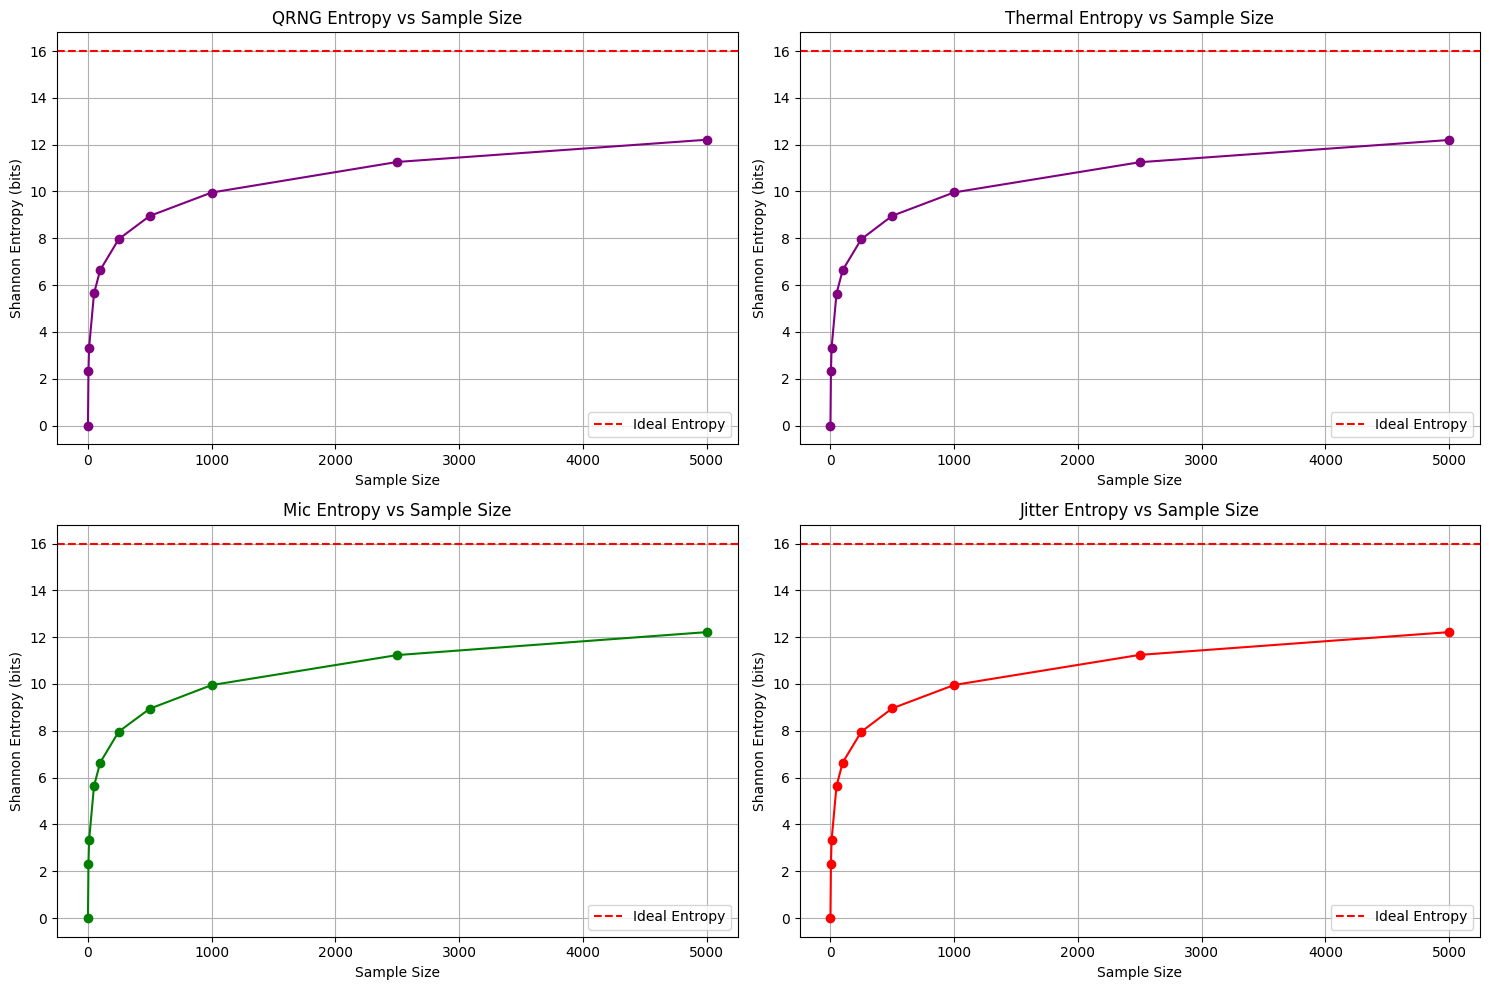

C:\Users\krish patel\AppData\Local\Temp\ipykernel_8104\2828442521.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels)


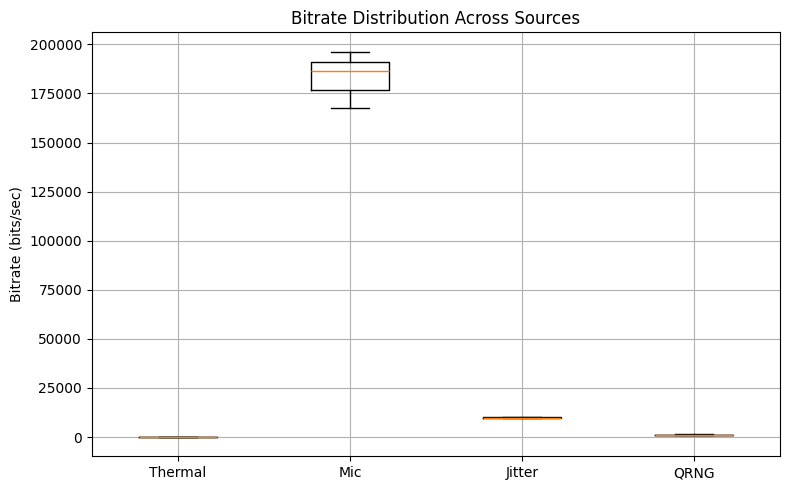


Entropy Summary:
Thermal - Size      1: -0.00 bits (ideal: 16 bits)
Thermal - Size      5: 2.32 bits (ideal: 16 bits)
Thermal - Size     10: 3.32 bits (ideal: 16 bits)
Thermal - Size     50: 5.64 bits (ideal: 16 bits)
Thermal - Size    100: 6.64 bits (ideal: 16 bits)
Thermal - Size    250: 7.96 bits (ideal: 16 bits)
Thermal - Size    500: 8.96 bits (ideal: 16 bits)
Thermal - Size   1000: 9.96 bits (ideal: 16 bits)
Thermal - Size   2500: 11.25 bits (ideal: 16 bits)
Thermal - Size   5000: 12.20 bits (ideal: 16 bits)

Mic - Size      1: -0.00 bits (ideal: 16 bits)
Mic - Size      5: 2.32 bits (ideal: 16 bits)
Mic - Size     10: 3.32 bits (ideal: 16 bits)
Mic - Size     50: 5.64 bits (ideal: 16 bits)
Mic - Size    100: 6.64 bits (ideal: 16 bits)
Mic - Size    250: 7.97 bits (ideal: 16 bits)
Mic - Size    500: 8.94 bits (ideal: 16 bits)
Mic - Size   1000: 9.95 bits (ideal: 16 bits)
Mic - Size   2500: 11.23 bits (ideal: 16 bits)
Mic - Size   5000: 12.21 bits (ideal: 16 bits)

Jitter - Size 

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# --- Entropy Plots ---
plt.figure(figsize=(15, 10))

# QRNG Entropy
plt.subplot(2, 2, 1)
plt.plot(SAMPLE_SIZES, entropy_values, marker='o', color='purple')
plt.axhline(y=BIT_LENGTH, color='red', linestyle='--', label='Ideal Entropy')
plt.title('QRNG Entropy vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Shannon Entropy (bits)')
plt.grid(True)
plt.legend()

# Thermal Entropy
plt.subplot(2, 2, 2)
plt.plot(SAMPLE_SIZES, thermal_entropy_values, marker='o', color='purple')
plt.axhline(y=BIT_LENGTH, color='red', linestyle='--', label='Ideal Entropy')
plt.title('Thermal Entropy vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Shannon Entropy (bits)')
plt.grid(True)
plt.legend()

# Mic Entropy
plt.subplot(2, 2, 3)
plt.plot(SAMPLE_SIZES, mic_entropy_values, marker='o', color='green')
plt.axhline(y=BIT_LENGTH, color='red', linestyle='--', label='Ideal Entropy')
plt.title('Mic Entropy vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Shannon Entropy (bits)')
plt.grid(True)
plt.legend()

# Jitter Entropy
plt.subplot(2, 2, 4)
plt.plot(SAMPLE_SIZES, jitter_entropy_values, marker='o', color='red')
plt.axhline(y=BIT_LENGTH, color='red', linestyle='--', label='Ideal Entropy')
plt.title('Jitter Entropy vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Shannon Entropy (bits)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Combined Bitrate Plot
labels = []
data_to_plot = []

if thermal_bitrates:
    labels.append('Thermal')
    data_to_plot.append(thermal_bitrates)
if mic_bitrates:
    labels.append('Mic')
    data_to_plot.append(mic_bitrates)
if jitter_bitrates:
    labels.append('Jitter')
    data_to_plot.append(jitter_bitrates)
if bitrates:  # QRNG bitrates
    labels.append('QRNG')
    data_to_plot.append(bitrates)

if data_to_plot:
    plt.figure(figsize=(8, 5))
    plt.boxplot(data_to_plot, labels=labels)
    plt.ylabel('Bitrate (bits/sec)')
    plt.title('Bitrate Distribution Across Sources')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    # Fallback if no data
    plt.figure(figsize=(6, 4))
    plt.text(0.5, 0.5, 'No successful bitrate measurements',
             ha='center', va='center', fontsize=12)
    plt.title('Bitrate Measurement Failed')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


print("\nEntropy Summary:")
for label, entropy_vals in zip(["Thermal", "Mic", "Jitter"],
                               [thermal_entropy_values, mic_entropy_values, jitter_entropy_values]):
    for size, val in zip(SAMPLE_SIZES, entropy_vals):
        print(f"{label} - Size {size:6d}: {val:.2f} bits (ideal: {BIT_LENGTH} bits)")
    print()

def summarize_bitrate(source_name, data):
    print(f"{source_name} Bitrate Summary:")
    print(f"  Mean   : {np.mean(data):.2f} bits/sec")
    print(f"  Std Dev: {np.std(data):.2f} bits/sec")
    print(f"  Min    : {np.min(data):.2f} bits/sec")
    print(f"  Max    : {np.max(data):.2f} bits/sec")
    print()

if thermal_bitrates:
    summarize_bitrate("Thermal", thermal_bitrates)
if mic_bitrates:
    summarize_bitrate("Mic", mic_bitrates)
if jitter_bitrates:
    summarize_bitrate("Jitter", jitter_bitrates)


### Part B: Easy as Pi!

In [54]:
def estimate_pi_qrng(num_points: int, qrng: QRNGaaS) -> float:
    circle_points = 0
    square_points = 0

    # Generate x and y coordinates in batches
    points_per_batch = 1000  # Adjust based on API limits and performance
    for i in range(0, num_points, points_per_batch):
        batch_size = min(points_per_batch, num_points - i)

        # Fetch random x and y coordinates in [-1, 1)
        rand_x = qrng.get_random_doubles_batched(batch_size, -1.0, 1.0)
        rand_y = qrng.get_random_doubles_batched(batch_size, -1.0, 1.0)

        if len(rand_x) != batch_size or len(rand_y) != batch_size:
            print(f"Warning: Insufficient random numbers received for batch {i}")
            continue

        # Process each point in the batch
        for x, y in zip(rand_x, rand_y):
            origin_dist = x**2 + y**2
            if origin_dist <= 1:
                circle_points += 1
            square_points += 1

    # Estimate Pi
    if square_points == 0:
        return 0.0
    pi_estimate = 4 * circle_points / square_points
    return pi_estimate

In [55]:
if __name__ == "__main__":
    INTERVAL = 50
    TOTAL_POINTS = INTERVAL ** 2
    qrng = QRNGaaS(API_KEY)
    pi = estimate_pi_qrng(TOTAL_POINTS, qrng)
    print(f"Final Estimation of Pi (QRNG) = {pi}")

Final Estimation of Pi (QRNG) = 3.2096
